# Notebook pour projet DCD

## Roadmap

1 - Import all metrics in an array of shape *metrics* × *species* × *values*

2 - Cluster *species* × *values* for each metric then compare to orthologs

3 - Analyse the repartition of values

In [1]:
import sklearn.cluster
import matplotlib.pyplot as plt
import numpy
import pandas
import glob
import plotly.express as px
import copy

## 1 - Import

In [2]:
arraylist = list()
metrics_list = glob.glob("Metrics/*.tsv")
for filename in metrics_list:
    csv_df = pandas.read_csv(filename, delimiter = "\t", index_col=0)
    arraylist.append(csv_df)

In [3]:
np_list = list()
for array in arraylist:
    shape = array.shape
    array_nonacol = array.dropna(axis=0, thresh = shape[1] - 10000)
    array_nona = array_nonacol.dropna(axis = 1)
    np_list.append(array_nona)

In [4]:
# we need all rows and columns names that are not common to all the arrays
columns = set(np_list[0].columns)
rows = set(np_list[0].index)
cols_todel = list()
rows_todel = list()

for array in np_list: # first get all common elements
    rows = rows.intersection(set(array.index))
    columns = columns.intersection(set(array.columns))

for array in np_list: # then get the diff for each array
    rows_todel.append(set(array.index) - rows)
    cols_todel.append(set(array.columns) - columns)

In [5]:
stackable_arrays = list()
for array, rows, cols in zip(np_list, rows_todel, cols_todel):
    temp = array.drop(index=rows)
    stackable_arrays.append(temp.drop(columns = cols))
array_predict = copy.deepcopy(stackable_arrays)

In [6]:
stacked_arrays = numpy.stack([i.to_numpy() for i in stackable_arrays])
stacked_arrays.shape

(6, 57, 597)

## 2 - Cluster for each metric then compare to orthologs

### Cluster

In [15]:
# from metrics : species : genes to genes : metrics
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[:,i,:].transpose())
genes_x_metrics = numpy.concatenate(to_merge)
genes_x_metrics.shape

(34029, 6)

In [8]:
sc = sklearn.cluster.OPTICS(min_samples=57).fit(genes_x_metrics)
max(sc.labels_)

34

### Compare

Create a count cluster : labels

In [9]:
labels = list()
for i in range(stacked_arrays.shape[1]):
    labels += list(stackable_arrays[0].columns)

In [10]:
counts_by_labels = dict()
for cluster, label in zip(sc.labels_, labels):
    if cluster not in counts_by_labels:
        counts_by_labels[cluster]=dict()
    if label not in counts_by_labels[cluster]:
        counts_by_labels[cluster][label]=0
    counts_by_labels[cluster][label] += 1

Then graph it as a stacked barplot

In [11]:
data = {"name": list(), "parent": list(), "value": list()}
for cluster in counts_by_labels:
    if not cluster == -1:
        for label in counts_by_labels[cluster]:
            data["name"].append(label)
            data["parent"].append(cluster)
            data["value"].append(counts_by_labels[cluster][label])

In [12]:
# parent is cluster
# character is ortholog
# values is count character by cluster
fig = px.bar(data, x="parent", y="value", color="name")
fig.show(renderer="browser")

Now let's analyse clusters : are they determined more by species or by orthology ? Since we have 57 species and 34 clusters it mays indicate something ; but then each group should contain a unique copy of each ortholog gene.

In [13]:
cluster_content = list()
for cluster in counts_by_labels:
    cluster_content.append((cluster,sum([counts_by_labels[cluster][i] for i in counts_by_labels[cluster]])/len([counts_by_labels[cluster][i] for i in counts_by_labels[cluster]])))
cluster_content

[(-1, 48.553691275167786),
 (26, 1.446808510638298),
 (13, 6.098522167487685),
 (2, 1.2361111111111112),
 (27, 1.4086021505376345),
 (11, 1.6296296296296295),
 (24, 1.6349206349206349),
 (3, 1.6026490066225165),
 (28, 1.2903225806451613),
 (10, 1.1403508771929824),
 (34, 1.9189189189189189),
 (19, 1.2307692307692308),
 (29, 1.353846153846154),
 (14, 1.3235294117647058),
 (15, 1.1904761904761905),
 (8, 1.381679389312977),
 (12, 1.2191780821917808),
 (6, 1.2903225806451613),
 (5, 1.2584269662921348),
 (33, 1.6829268292682926),
 (1, 1.6311475409836065),
 (31, 1.5957446808510638),
 (23, 1.2222222222222223),
 (17, 1.3736263736263736),
 (30, 1.7849462365591398),
 (25, 1.34375),
 (22, 1.1636363636363636),
 (0, 1.368421052631579),
 (18, 1.2266666666666666),
 (32, 1.4482758620689655),
 (20, 1.2463768115942029),
 (7, 1.2424242424242424),
 (4, 1.2253521126760563),
 (9, 1.1694915254237288),
 (16, 1.0923076923076922),
 (21, 1.3243243243243243)]

Average value is ~ 1 ; it confirm our hypothesis that the metrics are determined by species and so the clusters reflect the species. But why do we have the 13th cluster ?

In [14]:
sorted([[i, counts_by_labels[13][i]] for i in counts_by_labels[13]], key = lambda x: x[1])

[['2961', 1],
 ['79886', 1],
 ['56913', 1],
 ['506', 1],
 ['27190', 1],
 ['23234', 1],
 ['8464', 1],
 ['7172', 1],
 ['941', 1],
 ['8813', 1],
 ['25949', 1],
 ['29088', 1],
 ['8883', 1],
 ['94103', 1],
 ['79035', 1],
 ['51026', 1],
 ['84275', 1],
 ['283576', 1],
 ['874', 1],
 ['64757', 1],
 ['286451', 1],
 ['10577', 1],
 ['5129', 1],
 ['6750', 1],
 ['79642', 1],
 ['9113', 1],
 ['843', 1],
 ['80267', 1],
 ['25897', 1],
 ['126767', 1],
 ['11264', 1],
 ['26578', 1],
 ['7389', 1],
 ['83464', 1],
 ['11015', 1],
 ['51637', 1],
 ['890', 1],
 ['58527', 1],
 ['401546', 1],
 ['4548', 1],
 ['8539', 1],
 ['64841', 1],
 ['9470', 1],
 ['51804', 1],
 ['171177', 1],
 ['6697', 1],
 ['1143', 1],
 ['55584', 1],
 ['5648', 1],
 ['6425', 1],
 ['164284', 1],
 ['79768', 1],
 ['53836', 1],
 ['7374', 1],
 ['54757', 1],
 ['91975', 1],
 ['144577', 1],
 ['55180', 1],
 ['92591', 1],
 ['57168', 1],
 ['79689', 1],
 ['55734', 1],
 ['6001', 1],
 ['2302', 1],
 ['60386', 1],
 ['55248', 1],
 ['2643', 1],
 ['55176', 1],
 ['

Two orthologs groups are almost full (57 and 55) ; additionnal info on these genes tell us that they are associated one with immune response and the other with cell cycle. These are essential functions which implies selective pressure and limited evolution.
This may explain that genes cluster together. However, we need to check if other genes in other clusters have a similar profile.

## Is evolution at the origin of the previous clustering ?

In [15]:
#TODO prévoir une analyse d'alignements pour vérifier que les gènes du cluster 16 sont bien moins conservés que ceux du cluster 13

### Compare GC3 / GC

Compare clustering using rates at the 3rd position of the codon (synonymous pos, not selected) with clustering using rates for the gene.

In [16]:
conserved = pandas.read_csv("Metrics/metrics_GC3_exons.tsv", delimiter = "\t", index_col=0)
random = pandas.read_csv("metrics_GC_gene.tsv", delimiter = "\t", index_col = 0)

In [17]:
np_list = list()
for array in conserved, random:
    shape = array.shape
    array_nonacol = array.dropna(axis=0, thresh = shape[1] - 10000)
    array_nona = array_nonacol.dropna(axis = 1)
    np_list.append(array_nona)

In [18]:
# we need all rows and columns names that are not common to all the arrays
columns = set(np_list[0].columns)
rows = set(np_list[0].index)
cols_todel = list()
rows_todel = list()

for array in np_list: # first get all common elements
    rows = rows.intersection(set(array.index))
    columns = columns.intersection(set(array.columns))

for array in np_list: # then get the diff for each array
    rows_todel.append(set(array.index) - rows)
    cols_todel.append(set(array.columns) - columns)

In [19]:
stackable_arrays = list()
for array, rows, cols in zip(np_list, rows_todel, cols_todel):
    temp = array.drop(index=rows)
    stackable_arrays.append(temp.drop(columns = cols))

In [20]:
stacked_arrays = numpy.stack([i.to_numpy() for i in stackable_arrays])
stacked_arrays.shape

(2, 57, 659)

In [21]:
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[0,i,:].transpose().reshape(-1, 1))
genes_x_gc = numpy.concatenate(to_merge)
genes_x_gc.shape

(37563, 1)

In [22]:
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[1,i,:].transpose().reshape(-1, 1))
genes_x_gc3 = numpy.concatenate(to_merge)
genes_x_gc3.shape

(37563, 1)

In [23]:
sc = sklearn.cluster.OPTICS(min_samples=57).fit(genes_x_gc)
cluster_conserved = list(sc.labels_)
cluster_conserved

[-1,
 -1,
 -1,
 12,
 -1,
 -1,
 45,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 19,
 -1,
 -1,
 -1,
 11,
 -1,
 -1,
 37,
 -1,
 -1,
 60,
 68,
 -1,
 -1,
 -1,
 -1,
 41,
 -1,
 -1,
 -1,
 -1,
 17,
 7,
 -1,
 17,
 -1,
 -1,
 10,
 -1,
 -1,
 -1,
 -1,
 -1,
 73,
 14,
 31,
 -1,
 -1,
 -1,
 13,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 10,
 51,
 7,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 25,
 -1,
 -1,
 -1,
 11,
 10,
 31,
 -1,
 -1,
 -1,
 -1,
 -1,
 19,
 -1,
 -1,
 -1,
 -1,
 -1,
 23,
 -1,
 -1,
 -1,
 -1,
 -1,
 13,
 -1,
 61,
 -1,
 73,
 34,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 51,
 -1,
 -1,
 -1,
 -1,
 52,
 24,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 46,
 -1,
 -1,
 -1,
 -1,
 17,
 41,
 -1,
 11,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 43,
 -1,
 -1,
 -1,
 -1,
 64,
 -1,
 -1,
 -1,
 -1,
 -1,
 26,
 -1,
 -1,
 -1,
 -1,
 12,
 -1,
 31,
 -1,
 7,
 -1,
 -1,
 -1,
 12,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1

In [24]:
sc = sklearn.cluster.OPTICS(min_samples=57).fit(genes_x_gc3)
cluster_random = list(sc.labels_)
cluster_random

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 23,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 21,
 -1,
 -1,
 -1,
 -1,
 -1,
 32,
 -1,
 -1,
 -1,
 -1,
 -1,
 30,
 -1,
 -1,
 -1,
 -1,
 53,
 -1,
 -1,
 -1,
 66,
 70,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 6,
 28,
 -1,
 26,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 14,
 -1,
 -1,
 36,
 -1,
 40,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 30,
 -1,
 -1,
 -1,
 46,
 25,
 34,
 -1,
 -1,
 14,
 -1,
 23,
 -1,
 -1,
 -1,
 -1,
 20,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 70,
 46,
 71,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 10,
 -1,
 -1,
 72,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 26,
 -1,
 -1,
 68,
 13,
 -1,
 -1,
 5,
 18,
 24,
 -1,
 -1,
 -1,
 72,
 38,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 38,
 -1,
 -1,
 -1,
 -1,
 -1,
 -

Let's analyse these new clusters to see how they correlate with our previous clustering. First, let's make a count of genes by clusters.

In [25]:
labels = list()
for i in range(stacked_arrays.shape[1]):
    labels += list(stackable_arrays[0].columns)

In [26]:
gc_by_labels = dict()
for cluster, label in zip(cluster_conserved, labels):
    if cluster not in gc_by_labels:
        gc_by_labels[cluster]=dict()
    if label not in gc_by_labels[cluster]:
        gc_by_labels[cluster][label] = 0
    gc_by_labels[cluster][label] += 1

In [27]:
gc3_by_labels = dict()
for cluster, label in zip(cluster_random, labels):
    if cluster not in gc3_by_labels:
        gc3_by_labels[cluster]=dict()
    if label not in gc3_by_labels[cluster]:
        gc3_by_labels[cluster][label] = 0
    gc3_by_labels[cluster][label] += 1

In [28]:
data = {"name": list(), "parent": list(), "value": list()}
for cluster in gc_by_labels:
    if not cluster == -1:
        for label in gc_by_labels[cluster]:
            data["name"].append(label)
            data["parent"].append(cluster)
            data["value"].append(gc_by_labels[cluster][label])
fig = px.bar(data, x="parent", y="value", color="name")
fig.show(renderer="browser")

In [29]:
data = {"name": list(), "parent": list(), "value": list()}
for cluster in gc3_by_labels:
    if not cluster == -1:
        for label in gc3_by_labels[cluster]:
            data["name"].append(label)
            data["parent"].append(cluster)
            data["value"].append(gc3_by_labels[cluster][label])
fig = px.bar(data, x="parent", y="value", color="name")
fig.show(renderer="browser")

In [30]:
cluster_content_gc = list()
for cluster in gc_by_labels:
    cluster_content_gc.append((cluster,sum([gc_by_labels[cluster][i] for i in gc_by_labels[cluster]])/len([gc_by_labels[cluster][i] for i in gc_by_labels[cluster]])))
cluster_content_gc

[(-1, 40.32018209408194),
 (12, 2.293598233995585),
 (45, 1.118279569892473),
 (19, 1.1458333333333333),
 (11, 1.0686274509803921),
 (37, 1.2521739130434784),
 (60, 1.634703196347032),
 (68, 1.3766233766233766),
 (41, 1.3225806451612903),
 (17, 1.4559386973180077),
 (7, 1.297029702970297),
 (10, 1.1864406779661016),
 (73, 1.275),
 (14, 1.150943396226415),
 (31, 1.8581818181818182),
 (13, 1.0655737704918034),
 (51, 1.336283185840708),
 (25, 1.3773584905660377),
 (23, 1.3035714285714286),
 (61, 1.2333333333333334),
 (34, 1.1142857142857143),
 (52, 1.2359550561797752),
 (24, 1.121212121212121),
 (46, 1.1634615384615385),
 (43, 1.3377483443708609),
 (64, 1.103896103896104),
 (26, 1.3085106382978724),
 (62, 1.1643835616438356),
 (5, 1.1647058823529413),
 (15, 1.108910891089109),
 (65, 1.1379310344827587),
 (21, 1.3144654088050314),
 (42, 1.1886792452830188),
 (38, 1.095890410958904),
 (6, 1.2017543859649122),
 (18, 1.1063829787234043),
 (35, 1.110091743119266),
 (4, 1.2706766917293233),
 (2

In [31]:
cluster_content_gc3 = list()
for cluster in gc3_by_labels:
    cluster_content_gc3.append((cluster,sum([gc3_by_labels[cluster][i] for i in gc3_by_labels[cluster]])/len([gc3_by_labels[cluster][i] for i in gc3_by_labels[cluster]])))
cluster_content_gc3

[(-1, 44.23823975720789),
 (23, 1.284263959390863),
 (21, 1.1696428571428572),
 (32, 1.1578947368421053),
 (30, 1.5896414342629481),
 (53, 1.1372549019607843),
 (66, 1.5041322314049588),
 (70, 2.2941176470588234),
 (6, 1.3055555555555556),
 (28, 1.1981132075471699),
 (26, 1.2117647058823529),
 (14, 1.3439490445859872),
 (36, 1.1710526315789473),
 (40, 1.1868131868131868),
 (46, 1.19),
 (25, 1.2459016393442623),
 (34, 1.2882882882882882),
 (20, 1.2782608695652173),
 (71, 1.7419354838709677),
 (10, 1.1454545454545455),
 (72, 1.4545454545454546),
 (68, 1.3246753246753247),
 (13, 1.1875),
 (5, 1.2345679012345678),
 (18, 1.1170212765957446),
 (24, 1.1170212765957446),
 (38, 1.1884057971014492),
 (49, 1.5561497326203209),
 (57, 1.2307692307692308),
 (22, 1.2913385826771653),
 (63, 1.3737373737373737),
 (27, 1.1926605504587156),
 (31, 1.4871794871794872),
 (9, 1.3109243697478992),
 (51, 1.2318840579710144),
 (54, 1.2641509433962264),
 (35, 1.1388888888888888),
 (56, 1.1176470588235294),
 (37,

In [63]:
match_clusters = list()
for i in gc_by_labels:
    temp = list()
    for j in gc3_by_labels:
        size_intersect = len(set(gc_by_labels[i]).intersection(set(gc3_by_labels[j])))
        relative = size_intersect / sum([gc_by_labels[i][k] for k in gc_by_labels[i]]) *100
        temp.append((relative, i, j))
    match_clusters.append(sorted(temp, reverse=True)[0:2])
match_clusters

[[(2.4801475292612247, -1, -1), (0.9446388920251401, -1, 30)],
 [(43.59961501443696, 12, -1), (18.09432146294514, 12, 30)],
 [(89.42307692307693, 45, -1), (40.38461538461539, 45, 49)],
 [(87.27272727272727, 19, -1), (37.27272727272727, 19, 30)],
 [(93.57798165137615, 11, -1), (47.706422018348626, 11, 30)],
 [(79.86111111111111, 37, -1), (31.25, 37, 49)],
 [(61.1731843575419, 60, -1), (24.860335195530723, 60, 49)],
 [(72.64150943396226, 68, -1), (34.90566037735849, 68, 70)],
 [(75.60975609756098, 41, -1), (31.097560975609756, 41, 49)],
 [(68.6842105263158, 17, -1), (30.526315789473685, 17, 30)],
 [(77.09923664122137, 7, -1), (37.786259541984734, 7, 30)],
 [(84.28571428571429, 10, -1), (41.42857142857143, 10, 30)],
 [(78.43137254901961, 73, -1), (41.17647058823529, 73, 70)],
 [(86.88524590163934, 14, -1), (35.24590163934426, 14, 30)],
 [(53.8160469667319, 31, -1), (23.09197651663405, 31, 30)],
 [(93.84615384615384, 13, -1), (36.92307692307693, 13, 30)],
 [(74.83443708609272, 51, -1), (31

In [35]:
max((set([gene[0] for gene in differing]).intersection(counts_by_labels[cluster]), cluster) for cluster in counts_by_labels)

({'1315', '163786', '65977', '7389'}, -1)

No particular grouping is observable.

In [41]:
GC_count = 0
GC3_count = 0
for gene in differing:
    if gene[1] == 0:
        GC_count += 1
    else:
        GC3_count += 1
(GC_count, GC3_count)

(33, 161)

In [21]:
#array_graph = numpy.stack(([i.split("/")[1].split(".")[0] for i in metrics_list], sc.labels_))
array_graph = numpy.stack((stackable_arrays[0].columns.to_numpy(), sc.labels_))
array_graph

ValueError: all input arrays must have the same shape

In [46]:
stacked_arrays.shape

(3, 57, 609)

In [49]:
stacked_arrays[1,:,:].shape

(57, 609)

In [53]:
# from metrics : species : genes to genes : metrics
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[0,i,:].transpose())
genes_x_gc = numpy.concatenate(to_merge)
genes_x_gc.shape

(34713,)

In [48]:
df_graph = pandas.DataFrame(array_graph.transpose(), columns = ["File", "Cluster"])
df_graph["Cluster"] = pandas.to_numeric(df_graph["Cluster"])
df_graph

File  Cluster
0      4922        0
1    163786      144
2     65977      114
3    414149        3
4      7342      174
..      ...      ...
592   55632      168
593    5480       19
594   56892       90
595   26061       20
596    8417      155

[597 rows x 2 columns]

([<matplotlib.axis.YTick at 0x7f9ff9326c70>,
 [Text(0, 1, '57221'),
  Text(0, 2, '80271'),
  Text(0, 3, '9317'),
  Text(0, 4, '2775'),
  Text(0, 5, '3363'),
  Text(0, 6, '9545'),
  Text(0, 7, '8287'),
  Text(0, 8, '7103'),
  Text(0, 9, '84878'),
  Text(0, 10, '84307'),
  Text(0, 11, '51317'),
  Text(0, 12, '64375'),
  Text(0, 13, '8538'),
  Text(0, 14, '9971'),
  Text(0, 15, '79642'),
  Text(0, 16, '83903'),
  Text(0, 17, '151963'),
  Text(0, 18, '92591'),
  Text(0, 19, '57134'),
  Text(0, 20, '27123'),
  Text(0, 21, '201294'),
  Text(0, 22, '9175'),
  Text(0, 23, '647309'),
  Text(0, 24, '51232'),
  Text(0, 25, '9992'),
  Text(0, 26, '6237'),
  Text(0, 27, '79899'),
  Text(0, 28, '125336'),
  Text(0, 29, '977'),
  Text(0, 30, '65055'),
  Text(0, 31, '128869'),
  Text(0, 32, '55750'),
  Text(0, 33, '2984'),
  Text(0, 34, '64377'),
  Text(0, 35, '145389'),
  Text(0, 36, '3284'),
  Text(0, 37, '84787'),
  Text(0, 38, '10121'),
  Text(0, 39, '7133'),
  Text(0, 40, '54913'),
  Text(0, 41, 

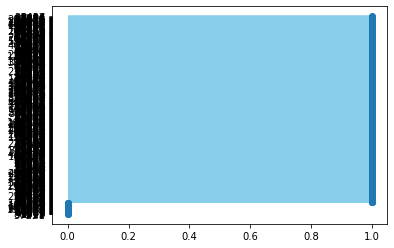

In [41]:
ordered_df = df_graph.sort_values(by='Cluster')
my_range=range(1,len(df_graph.index)+1)
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Cluster'], color='skyblue')
plt.plot(ordered_df['Cluster'], my_range, "o")
plt.yticks(my_range, ordered_df['File'])

In [60]:
[list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]

[3,
 6,
 6,
 3,
 2,
 4,
 4,
 2,
 3,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 4,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 5,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 4,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 5,
 4,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 5,
 3,
 3,
 4,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 6,
 4,
 4,
 4,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 4,
 2,
 3,
 2,
 3,
 4,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 4,
 3,
 2,
 4,
 5,
 2,
 2,
 2,
 2,
 4,
 5,
 2,
 3,
 4,
 3,
 2,
 3,
 3,
 3,
 3,
 4,
 2,
 2,
 2,
 3,
 5,
 4,
 5,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 5,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 4,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 4,
 4,
 2,
 2,
 3,
 2,
 3,
 5,
 3,
 2,
 3,
 2,
 2,
 2,
 3,
 6,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 6,
 6,
 3,
 3,
 2,
 4,
 42]

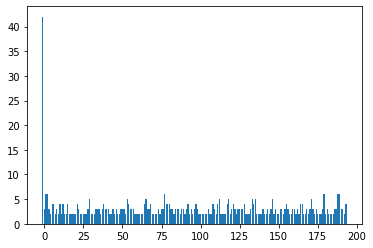

In [80]:
unique_values = [list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]
labels = list(set(df_graph["Cluster"]))
plt.bar(x = labels, height = unique_values)
plt.show()

In [78]:
labels = list(set(df_graph["Cluster"]))
numpy.array(labels).shape

(195,)

In [79]:
unique_values = [list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]
numpy.array(unique_values).shape

(195,)

In [66]:
len(set(cluster_random))

70

In [61]:
sum([gc_by_labels[1][k] for k in gc_by_labels[1]])

138

In [7]:

group_tab = numpy.zeros((1,57,597))

for j in range(0,57):
    for i in range(0,597):
        group_tab[0][j][i] = i
        

#array_predict.append(group_tab)        
array_predict = numpy.stack([i.to_numpy() for i in array_predict])

array_predict = numpy.append(array_predict,group_tab, axis=0 )
print(array_predict.shape) 

(7, 57, 597)


In [8]:
array_predict.shape

to_merge = list()
for i in range(array_predict.shape[1]):
    to_merge.append(array_predict[:,i,:].transpose())
genes_x_metrics_pred = numpy.concatenate(to_merge)
genes_x_metrics_pred.shape

X = genes_x_metrics_pred[:,0:6]
labels = genes_x_metrics_pred[:, 6]

dic_weight = {}
for i in range(0,597):
        dic_weight[i] = 1

In [9]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score


import numpy as np
import time

StratifiedKFold

def run_classifiers(X, labels, modeles):
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    liste_classee = []
    for mod in modeles:
        begin = time.time()
        modele = modeles[mod]
        cv_acc = cross_val_score(modele, X, labels, cv = kf)
        end = time.time()
        #cv_precision = cross_val_score(modele, X, labels, cv = kf, scoring = 'precision')
        #cv_auc = cross_val_score(modele, X, labels, cv = kf, scoring = 'roc_auc')
        print("Accuracy for {} is : {} +/- {} (in {} seconds)".format(mod,np.mean(cv_acc), np.std(cv_acc), end - begin))
        #print("Precision for {} is : {} +/- {} ".format(mod,np.mean(cv_precision),np.std(cv_precision) ))
        #print("AUC for {} is : {} +/- {} ".format(mod,np.mean(cv_auc),np.std(cv_auc) ))
        print()
        liste_classee.append((mod ,np.mean(cv_acc)))
    liste_classee.sort(key=lambda tup: tup[1], reverse= True)
    return liste_classee

def run_classifiers_all_forms(X, labels, modeles):
    
    # non traité
    print("Non traité")
    print()
    base_list = run_classifiers(X, labels, clfs)
    
    # MM Scaler 
    print("MinMax Scaler")
    print()
    MM_scaler = MinMaxScaler()
    MM_scaler.fit(X)
    X_norm_MM = MM_scaler.transform(X)
    MM_list = run_classifiers(X_norm_MM, labels, modeles)
    

    # Standard Scaler
    print("Standard Scaler")
    print()
    Standard_scaler = StandardScaler()
    Standard_scaler.fit(X)
    X_norm_Stand = Standard_scaler.transform(X)
    SS_list = run_classifiers(X_norm_Stand, labels, modeles)


    # PCA 
    print("PCA ")
    print()
    nb_variable = X.shape[1]
    pca = PCA(n_components = nb_variable)
    pca.fit(X_norm_Stand)
    X_pca = pca.transform(X_norm_Stand)
    PCA_list = run_classifiers(X_pca, labels, modeles)
    
    # Pour l'Exam
    print("meilleure accu base {} pour modele {}".format(base_list[0][1], base_list[0][0]))
    print("meilleure accu MM_norm {} pour modele {}".format(MM_list[0][1], MM_list[0][0]))
    print("meilleure accu SS_norm {} pour modele {}".format(SS_list[0][1], SS_list[0][0]))
    print("meilleure accu PCA {} pour modele {}".format(PCA_list[0][1], PCA_list[0][0]))

clfs = {
'RF': RandomForestClassifier(n_estimators=50, random_state=1),
'KNN': KNeighborsClassifier(n_neighbors=10),
'BAG' : BaggingClassifier(n_estimators = 50, random_state =1),
'ADA': AdaBoostClassifier(n_estimators = 50, random_state =1),
'MLP': MLPClassifier(hidden_layer_sizes= (50,20), alpha = 0.001, max_iter = 100, random_state =1),
'NB': GaussianNB()

}

In [18]:
run_classifiers_all_forms(X, labels, clfs)

Non traité

Accuracy for RF is : 0.2573981016192071 +/- 0.004081049800201967 (in 122.0989978313446 seconds)

Accuracy for KNN is : 0.037761908960004704 +/- 0.0007246071295623133 (in 1.788316011428833 seconds)

Accuracy for BAG is : 0.2549002321549267 +/- 0.003211362610449483 (in 305.19983887672424 seconds)

Accuracy for ADA is : 0.008816009873931059 +/- 0.0008175631222335977 (in 120.84413599967957 seconds)



/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP is : 0.010226571453760028 +/- 0.001301668258858626 (in 206.97159886360168 seconds)

Accuracy for NB is : 0.09065796820359107 +/- 0.0029655824882407044 (in 1.6700243949890137 seconds)

MinMax Scaler

Accuracy for RF is : 0.2578389021129037 +/- 0.00342981938945404 (in 121.48351383209229 seconds)

Accuracy for KNN is : 0.1726468600311499 +/- 0.0018229230855177421 (in 2.9179084300994873 seconds)

Accuracy for BAG is : 0.25584060654147933 +/- 0.003678153708804816 (in 305.8099408149719 seconds)

Accuracy for ADA is : 0.008816009873931059 +/- 0.0008175631222335977 (in 122.12152767181396 seconds)



/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP is : 0.09712304211114049 +/- 0.0028651655335240216 (in 242.75311946868896 seconds)

Accuracy for NB is : 0.09206852978342002 +/- 0.0037928200844343733 (in 1.8201186656951904 seconds)

Standard Scaler

Accuracy for RF is : 0.2571336213229892 +/- 0.004103839707391364 (in 123.17025113105774 seconds)

Accuracy for KNN is : 0.1846660201592759 +/- 0.0016101122609306967 (in 2.784668207168579 seconds)

Accuracy for BAG is : 0.254606365159129 +/- 0.003373971943408926 (in 305.89914631843567 seconds)

Accuracy for ADA is : 0.008816009873931059 +/- 0.0008175631222335977 (in 122.23471212387085 seconds)



/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP is : 0.15607276146815952 +/- 0.0028804962249476215 (in 241.84707403182983 seconds)

Accuracy for NB is : 0.0920097563842605 +/- 0.0038403368341864592 (in 1.6902358531951904 seconds)

PCA 

Accuracy for RF is : 0.22809956213817628 +/- 0.0005773570397128471 (in 130.6276617050171 seconds)

Accuracy for KNN is : 0.1846660201592759 +/- 0.0016101122609306967 (in 2.7405576705932617 seconds)

Accuracy for BAG is : 0.22759998824532016 +/- 0.0025996850397715467 (in 329.25322365760803 seconds)

Accuracy for ADA is : 0.005730406418055188 +/- 0.0006478417727540805 (in 128.59763717651367 seconds)



/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sophiane/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP is : 0.1508713156425402 +/- 0.0014932376521099647 (in 240.73914194107056 seconds)

Accuracy for NB is : 0.1131975667812748 +/- 0.0022174791477755414 (in 1.8164474964141846 seconds)

meilleure accu base 0.2573981016192071 pour modele RF
meilleure accu MM_norm 0.2578389021129037 pour modele RF
meilleure accu SS_norm 0.2571336213229892 pour modele RF
meilleure accu PCA 0.22809956213817628 pour modele RF


In [11]:
from sklearn.model_selection import train_test_split


X_train, X_test, labels_train, labels_test = train_test_split(X, labels, train_size = 0.5, random_state =1)
MM_scaler = MinMaxScaler()
MM_scaler.fit(X_train)
X_norm_MM_train = MM_scaler.transform(X_train)
X_norm_MM_test = MM_scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=50, random_state=1)
clf.fit(X_norm_MM_train, labels_train)
importances=clf.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]


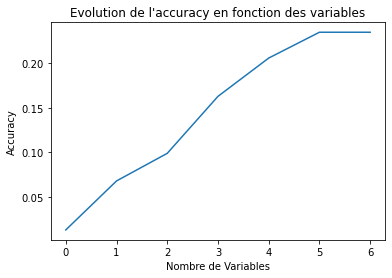

In [13]:
scores=np.zeros(X_norm_MM_train.shape[1]+1)
for f in np.arange(0, X_norm_MM_train.shape[1]+1):
    X1_f = X_norm_MM_train[:,sorted_idx[:f+1]]
    X2_f = X_norm_MM_test[:,sorted_idx[:f+1]]
    clf.fit(X1_f,labels_train)
    Yclf=clf.predict(X2_f)
    scores[f]=np.round(accuracy_score(labels_test,Yclf),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

listparam = [50,100, 200, 300, 400, 500]


criterion_p = ["gini", "entropy"]
class_w = ["balanced", "balanced_subsample"]


param_grid=dict(n_estimators=listparam, class_weight=class_w, criterion=criterion_p)
grid = GridSearchCV(RandomForestClassifier(), param_grid,cv=3, scoring='accuracy')
grid.fit(X_norm_MM_train[: ,sorted_idx[:5]],labels_train)



print(grid.best_params_)
print(grid.best_score_)
